In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
skin_df = pd.read_csv('hmnist_64_64_RBG.csv')

In [3]:
skin_df.head()


,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,191,152,194,191,153,195,192,149,192,194,...,185,154,180,186,156,184,182,152,173,2
1,24,13,23,24,14,28,37,24,46,61,...,26,15,29,27,15,28,24,13,25,2
2,185,129,140,192,136,151,198,142,156,198,...,152,120,138,144,113,123,115,81,84,2
3,24,11,19,36,19,30,64,38,50,91,...,27,13,16,25,12,16,24,9,14,2
4,138,94,117,158,113,138,178,133,161,191,...,140,106,118,108,77,92,67,40,55,2


In [4]:
X = skin_df.drop("label", axis=1).values
label = skin_df["label"].values

In [5]:
X.shape, label.shape

((10015, 12288), (10015,))

In [6]:
X_mean = np.mean(X)
X_std = np.std(X)
X = (X - X_mean)/X_std

In [7]:
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)

In [8]:
X_train_orig.shape, X_test.shape, y_train_orig.shape, y_test.shape

((9013, 12288), (1002, 12288), (9013,), (1002,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7210, 12288), (1803, 12288), (7210,), (1803,))

In [10]:
X_train = X_train.reshape(X_train.shape[0], *(64, 64, 3))
X_val = X_val.reshape(X_val.shape[0], *(64, 64, 3))
X_test = X_test.reshape(X_test.shape[0], *(64, 64, 3))
X_train.shape, X_val.shape, X_test.shape

((7210, 64, 64, 3), (1803, 64, 64, 3), (1002, 64, 64, 3))

In [11]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
y_train.shape, y_val.shape, y_test.shape

((7210, 7), (1803, 7), (1002, 7))

In [12]:
img_input = layers.Input(shape=(64, 64, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = tf.keras.optimizers.legacy.SGD(lr=0.001, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

C:\Users\dell6\anaconda3\lib\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496 

In [14]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
batch_size = 64
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\dell6\AppData\Local\Temp\ipykernel_17952\4120936303.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/30
112/112 [==============================] - 25s 211ms/step - loss: 1.3147 - accuracy: 0.6391 - val_loss: 1.1333 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 2/30
112/112 [==============================] - 23s 207ms/step - loss: 1.1289 - accuracy: 0.6672 - val_loss: 1.0881 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 3/30
112/112 [==============================] - 24s 211ms/step - loss: 1.1016 - accuracy: 0.6646 - val_loss: 1.0601 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 4/30
112/112 [==============================] - 24s 215ms/step - loss: 1.0733 - accuracy: 0.6634 - val_loss: 1.0441 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 5/30
112/112 [==============================] - 23s 208ms/step - loss: 1.0571 - accuracy: 0.6658 - val_loss: 1.0297 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 6/30
112/112 [==============================] - 25s 219ms/step - loss: 1.0476 - accuracy: 0.6647 - val_loss: 1.0260 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 7/30
112/112 [==============================] 

112/112 [==============================] - 23s 204ms/step - loss: 0.9734 - accuracy: 0.6615 - val_loss: 0.9654 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 22/30
112/112 [==============================] - 23s 203ms/step - loss: 0.9736 - accuracy: 0.6672 - val_loss: 0.9640 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 23/30
112/112 [==============================] - 23s 205ms/step - loss: 0.9694 - accuracy: 0.6651 - val_loss: 0.9590 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 24/30
112/112 [==============================] - 23s 204ms/step - loss: 0.9676 - accuracy: 0.6640 - val_loss: 0.9580 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 25/30
112/112 [==============================] - 23s 205ms/step - loss: 0.9643 - accuracy: 0.6615 - val_loss: 0.9578 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 26/30
112/112 [==============================] - 23s 204ms/step - loss: 0.9624 - accuracy: 0.6667 - val_loss: 0.9517 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 27/30
112/112 [==============================] - 23s

In [15]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("model.h5")

57/57 [==============================] - 1s 21ms/step - loss: 0.9415 - accuracy: 0.6689
Validation: accuracy = 0.668885  ;  loss_v = 0.941510
Test: accuracy = 0.679641  ;  loss = 0.919366


C:\Users\dell6\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training and validation loss')

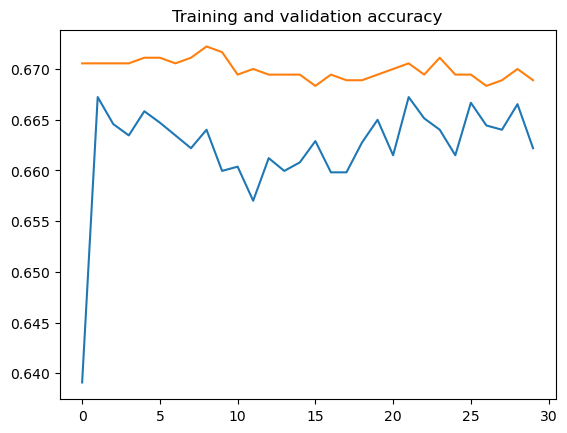

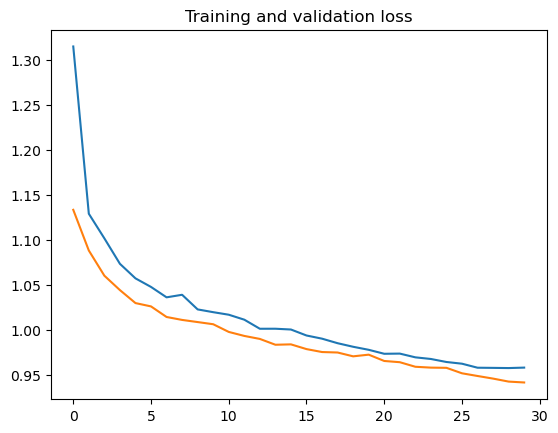

In [16]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
